In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-01-27 21:47:48.026703: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
#DATAPATH = '/Users/jiehyun/Jenna/UMassBoston/Research/Nathan_Arnett_Calcification/'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [12]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [13]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Softmax', shift_window=True, name='swin_unet')

2023-01-27 21:48:00.968427: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-27 21:48:01.137942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 21:48:01.137978: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-27 21:48:01.138009: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-27 21:48:01.138025: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-27 21:48:01.138995: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [14]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [13]:
#model = custom_unet(
#    input_shape=(512, 512, 1),
#    use_batch_norm=False,
#    num_classes=1,
#    filters=32,
#    dropout=0.5,
#    output_activation='sigmoid')

In [15]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
#from keras_unet.losses import jaccard_distance
from keras_unet_collection import losses

In [17]:
model.compile(loss='binary_crossentropy',
              #optimizer=keras.optimizers.Adam(lr=1e-3),
              optimizer = 'Adam',
              metrics=['accuracy', losses.dice_coef, iou, iou_thresholded])

In [16]:
#model.compile(optimizer = 'Adam',    
#              loss='binary_crossentropy', 
#              #loss = losses.focal_tversky,
#              metrics=[iou, iou_thresholded, dice_coef, 'accuracy'])

In [18]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=4, 
                    epochs=100,
                    validation_data=(X_val, y_val))

2023-01-27 21:48:52.729994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-27 21:48:52.749179: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-01-27 21:49:10.710119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-27 21:49:11.650285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-01-27 21:49:11.650620: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-27 21:49:11.687879: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-01-27 21:49:11.846615: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-01-27 21:49:12.392093: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-01-27 21:49:12.392116: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-01-27 21:49:12.39217

75/75 [==============================] - 40s 265ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2720e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 2/100
75/75 [==============================] - 16s 212ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2720e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 3/100
75/75 [==============================] - 16s 216ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 4/100
75/75 [==============================] - 16s 211ms/step - loss: 15.246

75/75 [==============================] - 16s 215ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 28/100
75/75 [==============================] - 16s 213ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 29/100
75/75 [==============================] - 16s 211ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 30/100
75/75 [==============================] - 16s 216ms/step - loss: 15.

75/75 [==============================] - 16s 213ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2720e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 54/100
75/75 [==============================] - 16s 213ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 55/100
75/75 [==============================] - 16s 212ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2720e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 56/100
75/75 [==============================] - 16s 211ms/step - loss: 15.

75/75 [==============================] - 16s 212ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 80/100
75/75 [==============================] - 16s 215ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 81/100
75/75 [==============================] - 16s 211ms/step - loss: 15.2460 - accuracy: 2.1366e-04 - dice_coef: 4.2721e-04 - iou: 2.1461e-04 - iou_thresholded: 2.1461e-04 - val_loss: 15.2453 - val_accuracy: 2.5864e-04 - val_dice_coef: 5.1712e-04 - val_iou: 2.5959e-04 - val_iou_thresholded: 2.5959e-04
Epoch 82/100
75/75 [==============================] - 16s 216ms/step - loss: 15.

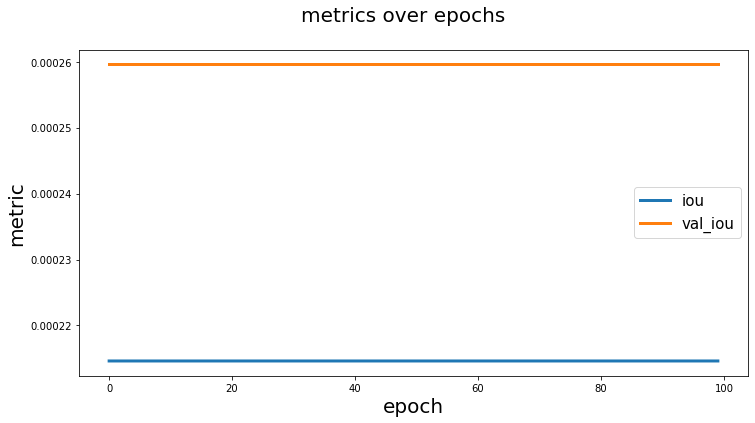

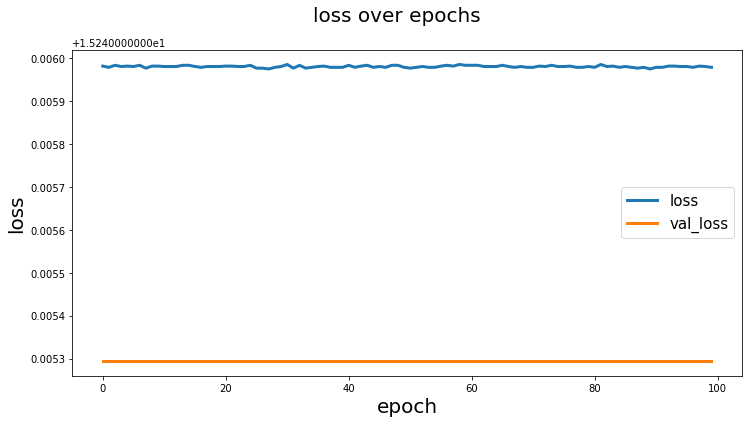

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_test)

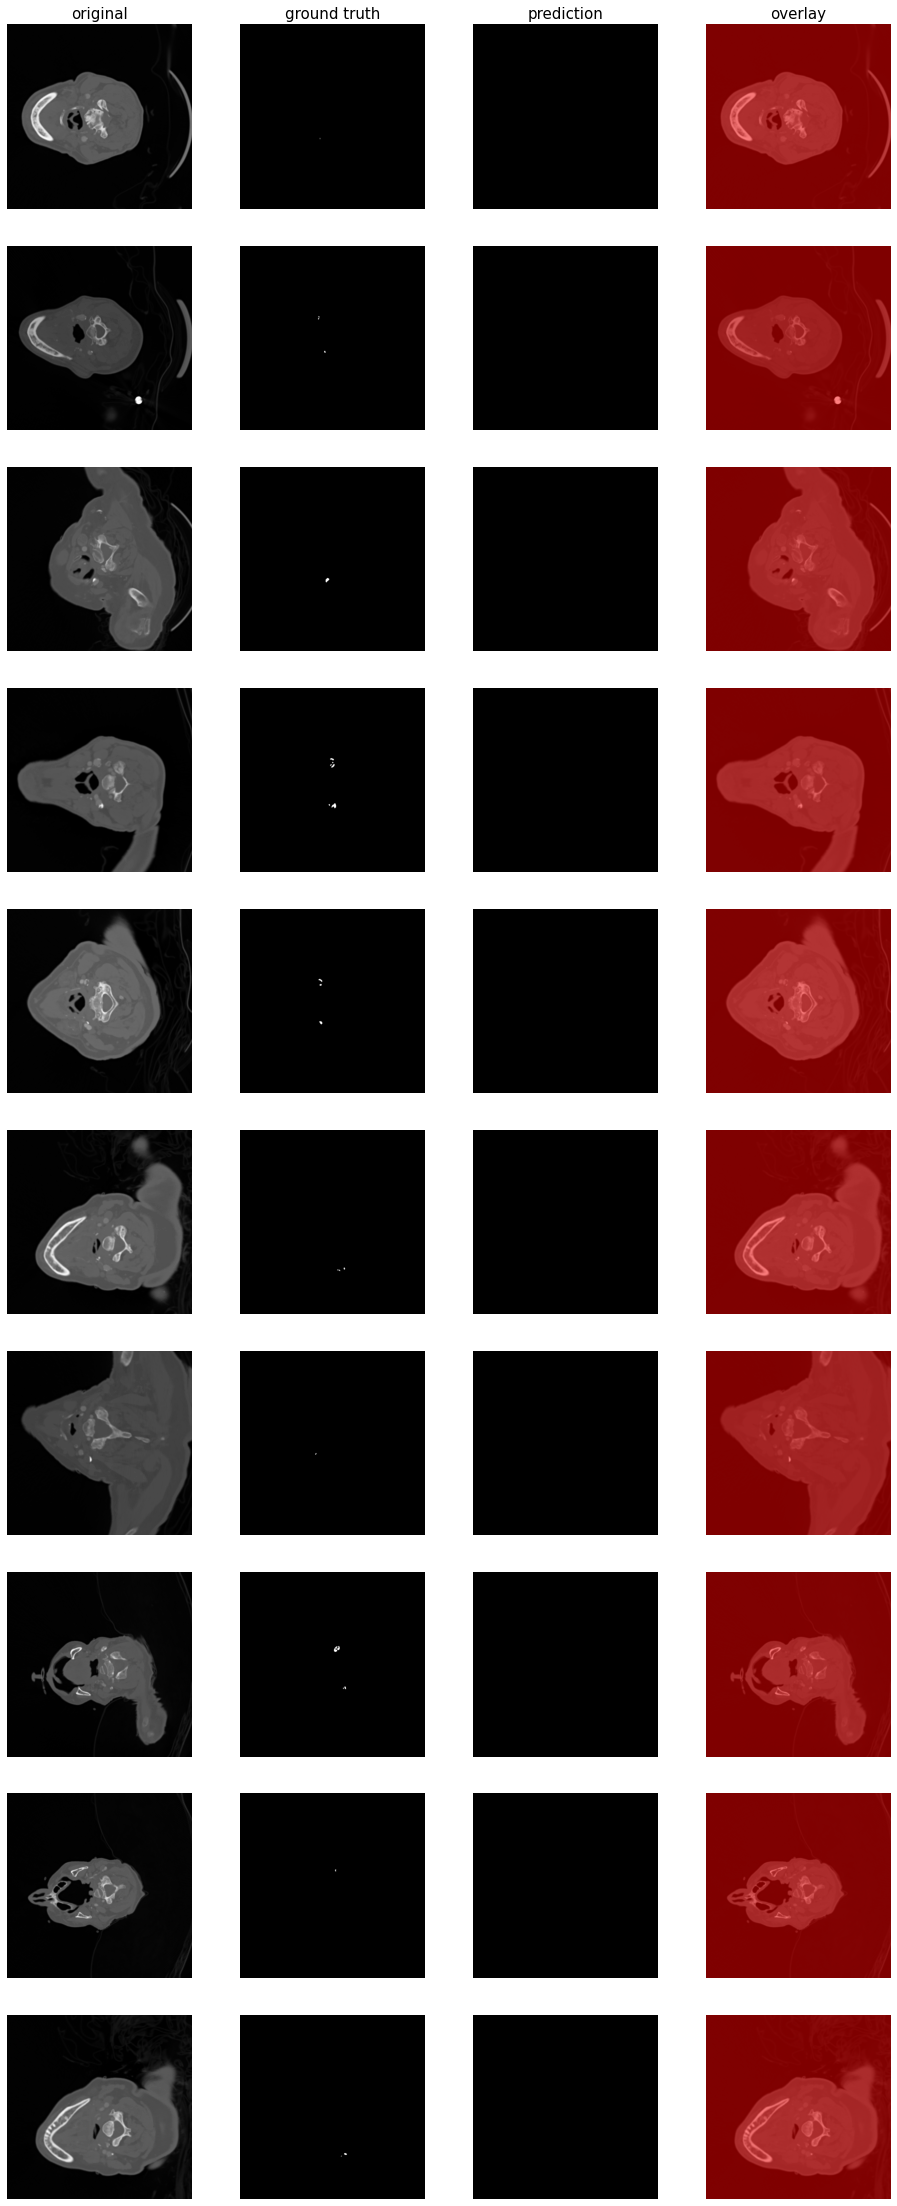

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [25]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 336ms/step - loss: 15.2453 - accuracy: 2.5844e-04 - dice_coef: 4.8733e-04 - iou: 2.4395e-04 - iou_thresholded: 2.4395e-04


ValueError: too many values to unpack (expected 3)